## UMAP clustering on re-trained with HDBSCAN (on UMAP)   
    - 102 epochs initial (kmeans)
    - 100 additional epochs (PIC)
    - train data:
    
```
Haus8 sgRNA #1	190219_195942-V	B12	
Haus8 sgRNA #2	190219_195942-V	E1	
Haus8 sgRNA #3	190219_195942-V	F2	
Haus8 sgRNA #4	190219_195942-V	G2	
DyncH1 sgRNA #3	190219_195942-V	A1	
Incenp sgRNA #1	190219_195942-V	G4	
Incenp sgRNA #2	190219_195942-V	G6	
Incenp sgRNA #3	190219_195942-V	H1	
Rad21 sgRNA #1	190219_195942-V	H3	
Rad21 sgRNA #2	190219_195942-V	H5	
Rad21 sgRNA #3	190219_195942-V	H7
```
    - test: 

```
Incenp sgRNA #1	190219_195942-V	G5	
Incenp sgRNA #2	190219_195942-V	G8	
No sgRNA Pt11_r01_c12
```
    - clustering with HDBSCAN

Additional cluster comparisons

In [1]:
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import anndata as ad
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from util import load_model
from util import AverageMeter, Logger, UnifLabelSampler
import shutil
import seaborn as sn
import scanpy.api as sc
import pandas as pd

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model=load_model('/home/aogorodnikov/model_alex_pos_continue/checkpoint.pth.tar')

=> loading checkpoint '/home/aogorodnikov/model_alex_pos_continue/checkpoint.pth.tar'
Loaded


In [4]:
model.cuda()
model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_si

In [5]:
model.top_layer = None
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

In [6]:
def compute_features(dataloader, model, N):
    
    batch_time = AverageMeter()
    end = time.time()
    model.eval()
    # discard the label information in the dataloader
    for i, (input_tensor, _) in enumerate(dataloader):
        with torch.no_grad():
            input_var = torch.autograd.Variable(input_tensor.cuda())
            aux = model(input_var).data.cpu().numpy()
            if i == 0:
                features = np.zeros((N, aux.shape[1])).astype('float32')

            if i < len(dataloader) - 1:
                features[i * 256: (i + 1) * 256] = aux.astype('float32')
            else:
                # special treatment for final batch
                features[i * 256:] = aux.astype('float32')

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        

    return features

In [7]:
data_dir = '/home/aogorodnikov/eval'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize]
dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose(tra))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256,
                                         num_workers=8,
                                         pin_memory=True)



In [8]:
%%time
features = compute_features(dataloader, model, len(dataset))

CPU times: user 2min 16s, sys: 3min 19s, total: 5min 36s
Wall time: 4min 28s


In [11]:
features.shape

(203428, 4096)

In [9]:
# get the file names
dataset.samples[0][0]
samples = [x[0] for x in dataset.samples]


In [10]:
# construct AnnData obj
adata = ad.AnnData(X=features, obs = samples)
adata.obs["well"] = adata.obs.iloc[:,0].str.extract(r'(Pt\d+_r\d+c\d+)')
adata.obs["image_ID"] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]



In [11]:
# downsample data
adata = adata[np.random.choice(range(0,adata.shape[0]), size=round(adata.shape[0]*0.2), replace=False),:]

In [12]:
adata

View of AnnData object with n_obs × n_vars = 40686 × 4096 
    obs: 0, 'well', 'image_ID'

### UMAP embedding without PCA

In [14]:
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [16]:
# euclidean

reducer = umap.UMAP(random_state=42, min_dist=0.0, n_components=2)
embedding_euc = reducer.fit_transform(adata.X)

In [25]:
reducer_10 = umap.UMAP(random_state=42, min_dist=0.0, n_components=30)
embedding_euc10 = reducer.fit_transform(adata.X)

In [26]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(embedding_euc10)

In [27]:
labels


array([0, 0, 0, ..., 0, 0, 0])

In [28]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['hdb'] = ["_".join(['lol', str(x)]) for x in labels]



#df_emb['leiden'] = adata.obs["leiden"].tolist()




df_emb.sort_values('image_ID').head()




,0,1,well,image_ID,hdb
11811,2.069121,0.002932,Pt04_r07c05,Pt04_r07c05_f01_0000,lol_0
588,-2.779888,1.589244,Pt04_r07c05,Pt04_r07c05_f01_0005,lol_0
34711,1.661277,1.098533,Pt04_r07c05,Pt04_r07c05_f01_0019,lol_0
4652,2.990627,0.863730,Pt04_r07c05,Pt04_r07c05_f01_0031,lol_0
27669,3.430199,0.984186,Pt04_r07c05,Pt04_r07c05_f01_0037,lol_0


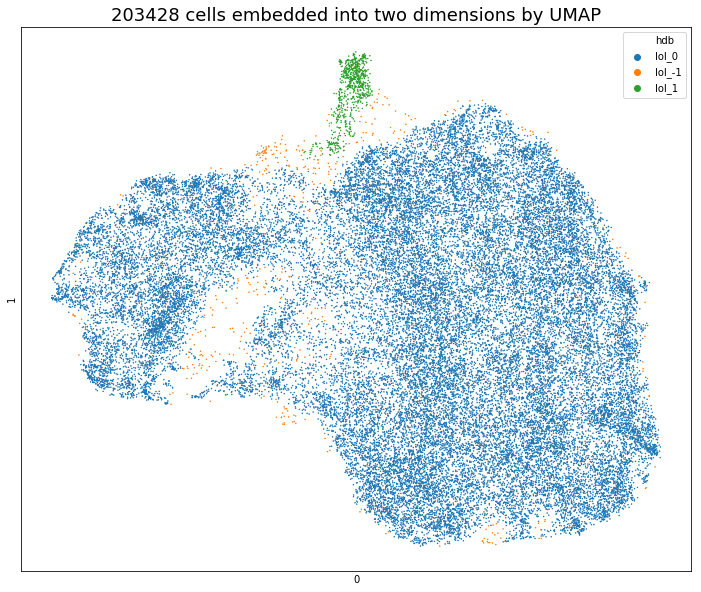

In [29]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.hdb, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

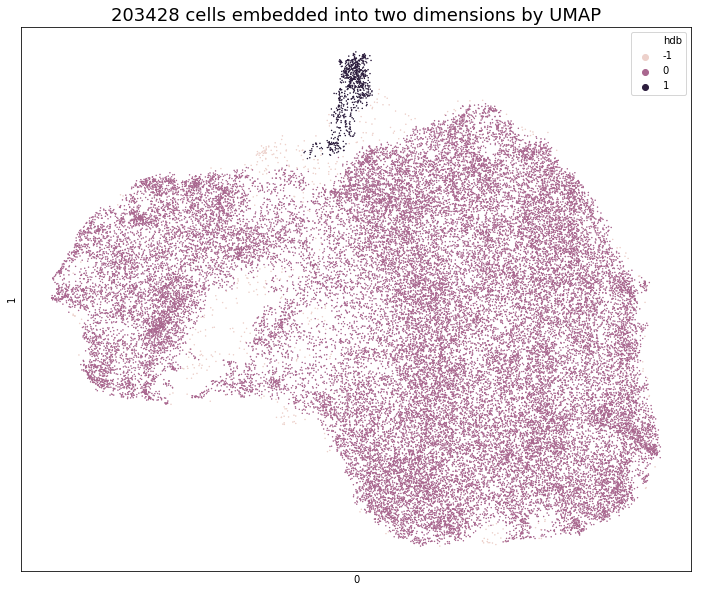

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.hdb, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

### Compare cluster sizes between samples  


In [31]:
## hdbscan
hdbscan_ls = []
for well in df_emb.well.unique():
    sum_well = len(df_emb.hdb[df_emb.well == well])
    for i in df_emb.hdb.unique():
        res = [well, i, len(df_emb.hdb[(df_emb.hdb == i) & (df_emb.well == well)]) / sum_well * 1e4]
        hdbscan_ls.append(res)

In [33]:
hdbscan_df = pd.DataFrame(hdbscan_ls, columns=['well', 'class', 'n_samp'])

In [35]:
hdbscan_df.head()

,well,class,n_samp
0,Pt04_r07c05,lol_0,9860.525462
1,Pt04_r07c05,lol_-1,87.577035
2,Pt04_r07c05,lol_1,51.897502
3,Pt11_r02c12,lol_0,9533.605749
4,Pt11_r02c12,lol_-1,115.541778


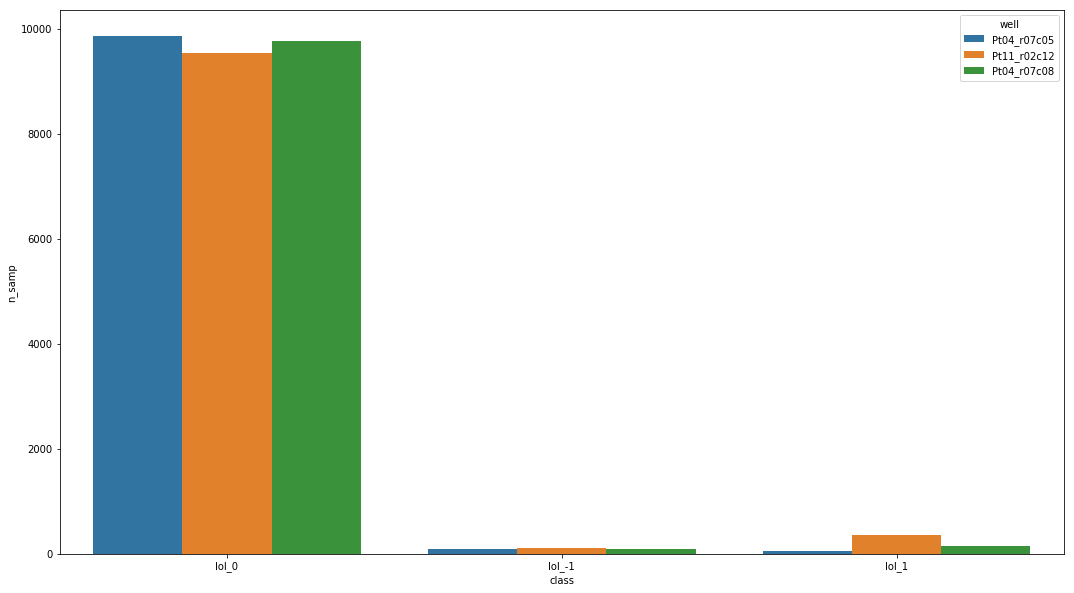

In [37]:
fig, ax = plt.subplots(figsize=(18, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=hdbscan_df)

### Clusters to export  


In [38]:
import re
import cv2

In [39]:
df_emb.head()

,0,1,well,image_ID,hdb
0,3.884393,0.051816,Pt04_r07c05,Pt04_r07c05_f50_0484,lol_0
1,1.734930,-2.766682,Pt04_r07c05,Pt04_r07c05_f28_0384,lol_0
2,1.845776,2.412233,Pt11_r02c12,Pt11_r02c12_f23_0537,lol_0
3,3.040208,-2.975061,Pt04_r07c08,Pt04_r07c08_f14_0574,lol_0
4,-0.239626,2.761295,Pt11_r02c12,Pt11_r02c12_f22_0307,lol_0


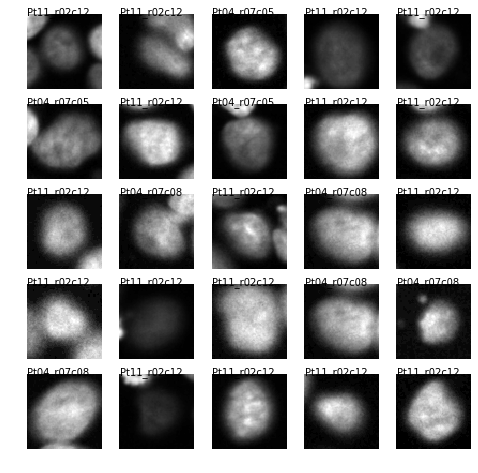

In [63]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = df_emb.loc[df_emb.hdb  == 'lol_1', "image_ID"].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread("".join(['/home/aogorodnikov/eval/data/',rand_select, ".tif"]), -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')